In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP import Fingerprint, Fingerprint_viz, graph_dict, graph_dataset, null_collate, Graph, Logger, time_to_str


In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  1128
number of successfully processed smiles:  1128


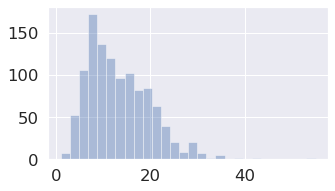

In [4]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "../data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

epochs = 80
batch_size =100

p_dropout= 0.2
fingerprint_dim = 50

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 3
K = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/delaney-processed.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    
# avoiding the last batch has too few samples by slightly tune the batch_size
while (len(train_fold[0]) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

batch size:  101


In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

255706
atom_preprocess.preprocess.0.linear.weight torch.Size([50, 39])
atom_preprocess.preprocess.0.linear.bias torch.Size([50])
atom_preprocess.preprocess.0.bn.weight torch.Size([50])
atom_preprocess.preprocess.0.bn.bias torch.Size([50])
atom_preprocess.preprocess.3.linear.weight torch.Size([50, 50])
atom_preprocess.preprocess.3.linear.bias torch.Size([50])
atom_preprocess.preprocess.3.bn.weight torch.Size([50])
atom_preprocess.preprocess.3.bn.bias torch.Size([50])
atom_preprocess.preprocess.6.linear.weight torch.Size([50, 50])
atom_preprocess.preprocess.6.linear.bias torch.Size([50])
atom_preprocess.preprocess.6.bn.weight torch.Size([50])
atom_preprocess.preprocess.6.bn.bias torch.Size([50])
bond_preprocess.preprocess.0.linear.weight torch.Size([50, 10])
bond_preprocess.preprocess.0.linear.bias torch.Size([50])
bond_preprocess.preprocess.0.bn.weight torch.Size([50])
bond_preprocess.preprocess.0.bn.bias torch.Size([50])
bond_preprocess.preprocess.3.linear.weight torch.Size([50, 50])
b

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [10]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 3
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [ ]:

log = Logger()
log.open(f'log/{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 800
    best_param["valid_MSE"] = 800
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))
        
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
#             if valid_MSE < 0.35:
#                  torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train_MSE | valid MSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"]))
    
    

epoch | loss | train MSE |  valid MSE |  time 
  0   | 10.1050 | 11.0007 | 11.1429 |  0 hr 00 min 
  1   | 4.8248  | 5.8628  | 6.4433  |  0 hr 00 min 
  2   | 2.4771  | 2.9797  | 3.8701  |  0 hr 00 min 
  3   | 1.6000  | 2.5733  | 3.5145  |  0 hr 00 min 
  4   | 1.3446  | 1.7444  | 2.0888  |  0 hr 00 min 
  5   | 1.3262  | 1.5561  | 1.8933  |  0 hr 00 min 
  6   | 1.2399  | 1.0302  | 1.2478  |  0 hr 00 min 
  7   | 1.0857  | 0.7783  | 1.0419  |  0 hr 00 min 
  8   | 0.8993  | 0.7158  | 0.8143  |  0 hr 00 min 
  9   | 0.8385  | 0.5703  | 0.6426  |  0 hr 00 min 
 10   | 0.7270  | 0.4473  | 0.5919  |  0 hr 00 min 
 11   | 0.6941  | 0.4692  | 0.5545  |  0 hr 00 min 
 12   | 0.6793  | 0.4031  | 0.5490  |  0 hr 00 min 
 13   | 0.5950  | 0.4912  | 0.6739  |  0 hr 00 min 
 14   | 0.5239  | 0.3668  | 0.5291  |  0 hr 00 min 
 15   | 0.4982  | 0.3130  | 0.4762  |  0 hr 00 min 
 16   | 0.5138  | 0.3489  | 0.5082  |  0 hr 00 min 
 17   | 0.4874  | 0.3274  | 0.5101  |  0 hr 00 min 
 18   | 0.4744  |

 157  | 0.1749  | 0.0638  | 0.4028  |  0 hr 04 min 
 158  | 0.1865  | 0.1139  | 0.4249  |  0 hr 04 min 
 159  | 0.1890  | 0.0711  | 0.3821  |  0 hr 04 min 
 160  | 0.1668  | 0.0666  | 0.4210  |  0 hr 04 min 
 161  | 0.1422  | 0.0820  | 0.4049  |  0 hr 04 min 
 162  | 0.1686  | 0.0733  | 0.3717  |  0 hr 04 min 
 163  | 0.1951  | 0.0683  | 0.3953  |  0 hr 04 min 
 164  | 0.1684  | 0.0942  | 0.4200  |  0 hr 04 min 
 165  | 0.1805  | 0.0702  | 0.3917  |  0 hr 04 min 
 166  | 0.2021  | 0.0630  | 0.3725  |  0 hr 04 min 
 167  | 0.1411  | 0.0825  | 0.3943  |  0 hr 04 min 
 168  | 0.1619  | 0.0681  | 0.3989  |  0 hr 04 min 
 169  | 0.1768  | 0.0690  | 0.3862  |  0 hr 04 min 
 170  | 0.1585  | 0.0570  | 0.3729  |  0 hr 04 min 
 171  | 0.1865  | 0.0641  | 0.3925  |  0 hr 04 min 
 172  | 0.2034  | 0.0966  | 0.4237  |  0 hr 04 min 
 173  | 0.1751  | 0.0621  | 0.4078  |  0 hr 04 min 
 174  | 0.2095  | 0.0651  | 0.4002  |  0 hr 04 min 
 175  | 0.1671  | 0.0728  | 0.3849  |  0 hr 04 min 
 176  | 0.12

Exception ignored in: <function _releaseLock at 0x7f1de8fe62f0>
Traceback (most recent call last):
  File "/data2/erikxiong/miniconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


 41   | 0.3106  | 0.1772  | 0.4972  |  0 hr 08 min 
 42   | 0.2904  | 0.1619  | 0.4435  |  0 hr 08 min 
 43   | 0.3000  | 0.1473  | 0.4263  |  0 hr 08 min 


In [ ]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

In [ ]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)